In [ ]:
# conda create --name lecture python=3.11
# conda install tensorflow
# !pip install tensorflow
# !pip install numpy
# !pip install matplotlib
# !pip install -U finance-datareader
# !pip install bs4
# !pip install sip >=5.0.1 <6
# !pip install pyqt5


  Using cached PyQt5-5.14.0.tar.gz (3.2 MB)


error: invalid-pyproject-build-system-requires

× Can not process pyQt5==5.14 from https://files.pythonhosted.org/packages/7c/5b/e760ec4f868cb77cee45b4554bf15d3fe6972176e89c4e3faac941213694/PyQt5-5.14.0.tar.gz
╰─> This package has an invalid `build-system.requires` key in pyproject.toml.
    It contains an invalid requirement: 'sip >=5.0.1 <6'

note: This is an issue with the package mentioned above, not pip.
hint: See PEP 518 for the detailed specification.


In [19]:
import FinanceDataReader as fdr
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout 
# from tensorflow.keras import SimpleRNN, GRU, LSTM   # ModuleNotFoundError: No module named 'tensorflow.keras'
import tensorflow as tf

In [ ]:
# model = tf.keras.Sequential([
#     tf.keras.layers.SimpleRNN(64),
#     tf.keras.layers.Dense(10, activation='softmax')
# ])

In [20]:
# 범위를 0 ~ 1 로 normalized 
def MinMaxScaler(data):
    """최솟값과 최댓값을 이용하여 0 ~ 1 값으로 변환"""
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    # 0으로 나누기 에러가 발생하지 않도록 매우 작은 값(1e-7)을 더해서 나눔
    return numerator / (denominator + 1e-7)

df = fdr.DataReader('005930', '2018-05-04', '2020-01-22')
dfx = df[['Open','High','Low','Volume', 'Close']]
dfx = MinMaxScaler(dfx)
dfy = dfx[['Close']]
dfx = dfx[['Open','High','Low','Volume']]

In [ ]:
# 두 데이터를 리스트 형태로 저장
x = dfx.values.tolist() # open, high, log, volume, 데이터
y = dfy.values.tolist() # close 데이터
#ex) 1월 1일 ~ 1월 10일까지의 OHLV 데이터로 1월 11일 종가 (Close) 예측
#ex) 1월 2일 ~ 1월 11일까지의 OHLV 데이터로 1월 12일 종가 (Close) 예측
window_size = 10
data_x = []
data_y = []
for i in range(len(y) - window_size):
    _x = x[i : i + window_size] # 다음 날 종가(i+windows_size)는 포함되지 않음
    _y = y[i + window_size]     # 다음 날 종가
    data_x.append(_x)
    data_y.append(_y)


In [22]:
train_size = int(len(data_y) * 0.7)
val_size = int(len(data_y) * 0.2)
train_x = np.array(data_x[0 : train_size])
train_y = np.array(data_y[0 : train_size])
val_x = np.array(data_x[train_size:train_size+val_size])
val_y = np.array(data_y[train_size:train_size+val_size])
test_size = len(data_y) - train_size - val_size
test_x = np.array(data_x[train_size+val_size: len(data_x)])
test_y = np.array(data_y[train_size+val_size: len(data_y)])
print('훈련 데이터의 크기 :', train_x.shape, train_y.shape)
print('검증 데이터의 크기 :', val_x.shape, val_y.shape)
print('테스트 데이터의 크기 :', test_x.shape, test_y.shape)


훈련 데이터의 크기 : (287, 10, 4) (287, 1)
검증 데이터의 크기 : (82, 10, 4) (82, 1)
테스트 데이터의 크기 : (42, 10, 4) (42, 1)


# MODEL CONSTRUCTION (RNN)

In [23]:
# RNN 모델
model = Sequential()
model.add(SimpleRNN(units=20, activation='tanh', return_sequences=True, input_shape=(10, 4)))
model.add(Dropout(0.1))
model.add(SimpleRNN(units=20, activation='tanh'))
model.add(Dropout(0.1))
model.add(Dense(units=1))
model.summary()
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(train_x, train_y, validation_data = (val_x, val_y), epochs=70, batch_size=30)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 10, 20)            500       
_________________________________________________________________
dropout (Dropout)            (None, 10, 20)            0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 20)                820       
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 1,341
Trainable params: 1,341
Non-trainable params: 0
_________________________________________________________________


AttributeError: module 'tensorflow.python.distribute.input_lib' has no attribute 'DistributedDatasetInterface'

In [25]:
# RNN 모델을 tf.keras 네임스페이스를 사용하여 정의
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(units=20, activation='tanh', return_sequences=True, input_shape=(10, 4)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.SimpleRNN(units=20, activation='tanh'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(units=1)
])

# 모델 요약
model.summary()

# 모델 컴파일 (optimizer와 loss는 문자열로 지정 가능)
model.compile(optimizer='adam', loss='mean_squared_error')

# 모델 학습
history = model.fit(train_x, train_y, validation_data=(val_x, val_y), epochs=70, batch_size=30)

c:\Users\user\miniconda3\envs\lecture\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)        │ (None, 10, 20)         │           500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 20)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,341 (5.24 KB)

 Trainable params: 1,341 (5.24 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/70
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.5947 - val_loss: 0.0450
Epoch 2/70
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1082 - val_loss: 0.0214
Epoch 3/70
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0877 - val_loss: 0.0628
Epoch 4/70
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0695 - val_loss: 0.0350
Epoch 5/70
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0860 - val_loss: 0.0139
Epoch 6/70
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0499 - val_loss: 0.0178
Epoch 7/70
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0449 - val_loss: 0.0067
Epoch 8/70
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0443 - val_loss: 0.0046
Epoch 9/70
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0368 - val_loss: 0.0058
Epoch 10/70
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0353 - val_loss: 0.0032
Epoch 11/70
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0326 - val_loss: 0.0045
Epoch 12/70
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0316 - val_l

# MODEL CONSTRUCTION (GRU)

In [ ]:
# # GRU 모델
# model = Sequential()
# model.add(GRU(units=20, activation='tanh', return_sequences=True, input_shape=(10, 4)))
# model.add(Dropout(0.1))
# model.add(GRU(units=20, activation='tanh'))
# model.add(Dropout(0.1))
# model.add(Dense(units=1))
# model.summary()

# model.compile(optimizer='adam', loss='mean_squared_error')
# history = model.fit(train_x, train_y, validation_data = (val_x, val_y), epochs=70, batch_size=30)

In [26]:
# GRU 모델을 tf.keras 네임스페이스를 사용하여 정의
model = tf.keras.Sequential([
    tf.keras.layers.GRU(units=20, activation='tanh', return_sequences=True, input_shape=(10, 4)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.GRU(units=20, activation='tanh'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(units=1)
])

# 모델 요약
model.summary()

# 모델 컴파일
model.compile(optimizer='adam', loss='mean_squared_error')

# 모델 학습
history = model.fit(train_x, train_y, validation_data=(val_x, val_y), epochs=70, batch_size=30)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 10, 20)         │         1,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 20)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 20)             │         2,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,101 (16.02 KB)

 Trainable params: 4,101 (16.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/70
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0561 - val_loss: 0.0074
Epoch 2/70
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0101 - val_loss: 0.0050
Epoch 3/70
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0077 - val_loss: 0.0173
Epoch 4/70
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0074 - val_loss: 0.0079
Epoch 5/70
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 6/70
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0051 - val_loss: 0.0062
Epoch 7/70
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0041 - val_loss: 0.0042
Epoch 8/70
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0036 - val_loss: 0.0042
Epoch 9/70
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0036 - val_loss: 0.0039
Epoch 10/70
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 11/70
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0026 - val_loss: 0.0034
Epoch 12/70
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0032 - val_l

# MODEL CONSTRUCTION (LSTM)

In [ ]:
# # LSTM 모델
# model = Sequential()
# model.add(LSTM(units=20, activation='tanh', return_sequences=True, input_shape=(10, 4)))
# model.add(Dropout(0.1))
# model.add(LSTM(units=20, activation='tanh'))
# model.add(Dropout(0.1))
# model.add(Dense(units=1))
# model.summary()

# model.compile(optimizer='adam', loss='mean_squared_error')
# history = model.fit(train_x, train_y, validation_data = (val_x, val_y), epochs=70, batch_size=30)

In [27]:
# LSTM 모델을 tf.keras 네임스페이스를 사용하여 정의
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(units=20, activation='tanh', return_sequences=True, input_shape=(10, 4)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.LSTM(units=20, activation='tanh'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(units=1)
])

# 모델 요약
model.summary()

# 모델 컴파일
model.compile(optimizer='adam', loss='mean_squared_error')

# 모델 학습
history = model.fit(train_x, train_y, validation_data=(val_x, val_y), epochs=70, batch_size=30)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 20)         │         2,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 10, 20)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 20)             │         3,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,301 (20.71 KB)

 Trainable params: 5,301 (20.71 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/70
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0915 - val_loss: 0.0724
Epoch 2/70
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0183 - val_loss: 0.0079
Epoch 3/70
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0080 - val_loss: 0.0059
Epoch 4/70
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0060 - val_loss: 0.0145
Epoch 5/70
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0057 - val_loss: 0.0119
Epoch 6/70
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0063 - val_loss: 0.0078
Epoch 7/70
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0050 - val_loss: 0.0080
Epoch 8/70
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0049 - val_loss: 0.0078
Epoch 9/70
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0049 - val_loss: 0.0072
Epoch 10/70
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0044 - val_loss: 0.0067
Epoch 11/70
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0049 - val_loss: 0.0063
Epoch 12/70
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0046 - val_

# 차트까지 종합 소스

c:\Users\user\miniconda3\envs\lecture\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


--- RNN 모델 학습 시작 ---
--- GRU 모델 학습 시작 ---
--- LSTM 모델 학습 시작 ---
--- 예측 및 시각화 시작 ---
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000025DE1C56980> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step


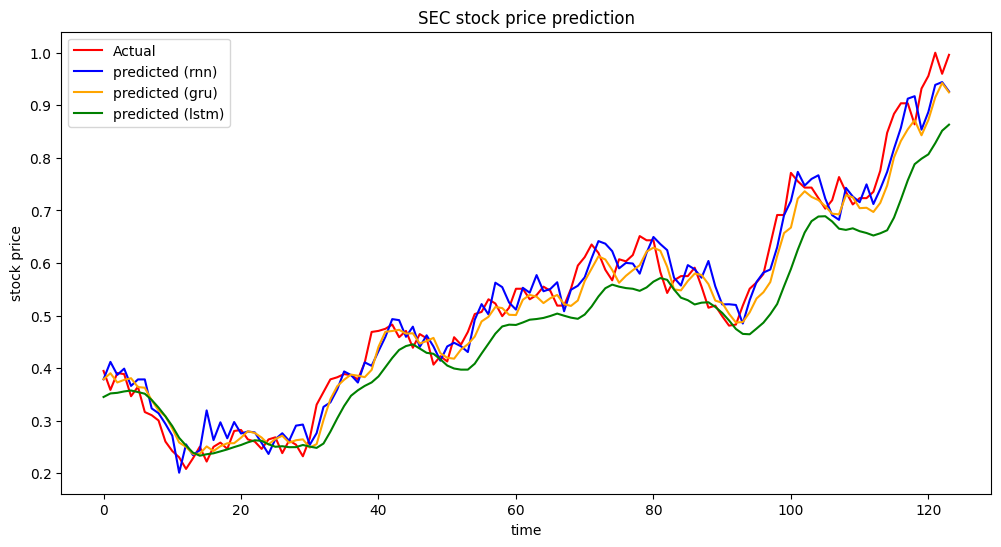

In [28]:
import tensorflow as tf
import numpy as np
import pandas as pd
import FinanceDataReader as fdr
import matplotlib.pyplot as plt

# 1. 데이터 준비
# -----------------------------------------------------------------------------
# 최솟값과 최댓값을 이용하여 0 ~ 1 값으로 변환하는 함수
def MinMaxScaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    return numerator / (denominator + 1e-7)

# 시계열 데이터를 RNN 입출력에 맞게 변환하는 함수
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series) - seq_length):
        _x = time_series[i:i + seq_length, :]
        _y = time_series[i + seq_length, [-1]]  # Target: 다음 날의 'Close' 가격
        dataX.append(_x)
        dataY.append(_y)
    return np.array(dataX), np.array(dataY)

# 데이터 로딩 및 정규화
df = fdr.DataReader('005930', '2018-05-04', '2020-01-22')
dfx = df[['Open', 'High', 'Low', 'Volume', 'Close']]
dfx = MinMaxScaler(dfx)
dfy = dfx[['Close']]

# Pandas DataFrame을 Numpy 배열로 변환
data = dfx.values
seq_length = 10  # 10일치 데이터로 다음 날 주가를 예측

# 시계열 데이터셋 생성
x, y = build_dataset(data, seq_length)

# 훈련 데이터와 테스트 데이터 분리 (70% 훈련, 30% 테스트)
train_size = int(len(y) * 0.7)
train_x, test_x = x[0:train_size], x[train_size:len(x)]
train_y, test_y = y[0:train_size], y[train_size:len(y)]

# 2. 모델 정의 및 학습
# -----------------------------------------------------------------------------
# RNN, GRU, LSTM 모델 정의
rnn_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(units=20, activation='tanh', return_sequences=True, input_shape=(seq_length, 5)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.SimpleRNN(units=20, activation='tanh'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(units=1)
])

gru_model = tf.keras.Sequential([
    tf.keras.layers.GRU(units=20, activation='tanh', return_sequences=True, input_shape=(seq_length, 5)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.GRU(units=20, activation='tanh'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(units=1)
])

lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(units=20, activation='tanh', return_sequences=True, input_shape=(seq_length, 5)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.LSTM(units=20, activation='tanh'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(units=1)
])

# 각 모델 컴파일
rnn_model.compile(optimizer='adam', loss='mean_squared_error')
gru_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# 각 모델 학습 (학습 과정을 보려면 verbose=1로 변경)
print("--- RNN 모델 학습 시작 ---")
rnn_model.fit(train_x, train_y, epochs=70, batch_size=30, verbose=0)

print("--- GRU 모델 학습 시작 ---")
gru_model.fit(train_x, train_y, epochs=70, batch_size=30, verbose=0)

print("--- LSTM 모델 학습 시작 ---")
lstm_model.fit(train_x, train_y, epochs=70, batch_size=30, verbose=0)


# 3. 예측 및 시각화
# -----------------------------------------------------------------------------
print("--- 예측 및 시각화 시작 ---")

# 각 모델로 테스트 데이터 예측
rnn_pred = rnn_model.predict(test_x)
gru_pred = gru_model.predict(test_x)
lstm_pred = lstm_model.predict(test_x)

# 차트 그리기
plt.figure(figsize=(12, 6))
plt.title('SEC stock price prediction')
plt.xlabel('time')
plt.ylabel('stock price')

plt.plot(test_y, label='Actual', color='red')
plt.plot(rnn_pred, label='predicted (rnn)', color='blue')
plt.plot(gru_pred, label='predicted (gru)', color='orange')
plt.plot(lstm_pred, label='predicted (lstm)', color='green')

plt.legend()
plt.show()